In [ ]:
!pip install odc.stac planetary_computer rioxarray zarr coiled geogif stackstac geopandas ipyleaflet

## Imports

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as ptf
from torch.utils.data import Dataset, DataLoader
import numpy as np
import warnings
import math
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import odc.stac
import xarray as xr
import planetary_computer
import pystac_client
import rioxarray as rxr
import pyproj
import geopandas as gpd
import pandas as pd
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt
import geopandas as gpd
import pyproj
import zarr
import dask.array as da
import time
import rasterio

import datetime as dt
import coiled
import distributed
import dask
import ipyleaflet
import IPython.display as dsp
import geogif
import stackstac
import time

from dask.diagnostics import ProgressBar
from scipy import ndimage
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
from pystac.extensions.eo import EOExtension as eo

# Constants
DEBUG_MODE = False
LEGEND_MIN = 270
LEGEND_MAX = 350
TEST_POINT = 1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Landsat/MODIS Connector

In [ ]:
def access_landsat_modis(
    gdf,
    date_min="2020",
    date_max="2024",
    cloud_cover=10):

    catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace)


    # Define the constraints of the image of interest.
    bbox_of_interest = gdf["geometry"].total_bounds
    time_of_interest = date_min + '/' + date_max;

    search_landsat = catalog.search(
    collections = ["landsat-c2-l2"],
    bbox = bbox_of_interest,
    datetime = time_of_interest,
    query = {"eo:cloud_cover": {"lt": cloud_cover},
           "platform": {"in": ["landsat-8", "landsat-9"]},
             },
    )

    search_modis = catalog.search(
          collections=["modis-11A1-061"],
          bbox=bbox_of_interest,
          datetime=time_of_interest,
          query={"eo:cloud_cover": {"lt": cloud_cover},
                "platform": {"in": ["terra", "aqua"]}
                },
      )

    modis_items = planetary_computer.sign(search_modis)
    landsat_items = planetary_computer.sign(search_landsat)


    # obtain all the images we can use for our TPD.
    TPDs, dates = getAllTPDs(modis_items, landsat_items)

    flattened_modis = []
    flattened_landsat = []
    modis_dates = []

    for i in range(1, len(TPDs) + 1):
      flattened_modis.extend(TPDs[i][0])
      flattened_landsat.extend(TPDs[i][1])
      modis_dates.extend([dates[(i - 1)*3], dates[(i - 1)*3 + 1], dates[(i - 1)*3 + 2]])

    prepped_modis_data = preprocess_modis(flattened_modis, modis_dates, bbox_of_interest);
    prepped_landsat_data = preprocess_landsat(flattened_landsat, bbox_of_interest);


    for i in range(len(flattened_modis)):
      datetime_modis = pd.to_datetime(prepped_modis_data.isel(time=i).time.to_pandas()).strftime("%Y-%m-%d")
      datetime_landsat = pd.to_datetime(prepped_landsat_data.isel(time=i).time.to_pandas()).strftime("%Y-%m-%d")
      assert datetime_landsat == dates[i]
      assert datetime_modis == dates[i]

    print("Landset and MODIS checks clear! Dates from prepped data and TPDs are in sync.")


    idx = 0
    for i in range(1, len(TPDs) + 1):
      for j in range(len(TPDs[i][1])):
        TPDs[i][0][j] = prepped_modis_data.isel(time=idx)
        TPDs[i][1][j] = prepped_landsat_data.isel(time=idx)
        idx += 1

    print("Made it to the end of connectors successfully!")
    return TPDs


def getAllTPDs(modis_coll, landsat_coll):

  modis_items = dict()
  landsat_items = dict()
  for item in modis_coll:
    julian_date = f"{item.id[11:16]}"
    standard_date = dt.datetime.strptime(julian_date, '%y%j')
    modis_items[f'{standard_date.strftime("%Y-%m-%d")}'] = item

  for item in landsat_coll:
    concat_date = f"{item.id[17:25]}"
    standard_date = dt.datetime.strptime(concat_date, '%Y%m%d')
    landsat_items[f'{standard_date.strftime("%Y-%m-%d")}'] = item

  valid_image_pairs = dict() # date : (modis, landsat)
  source = landsat_items if len(landsat_items) <= len(modis_items) else modis_items
  dest = modis_items if len(landsat_items) <= len(modis_items) else landsat_items
  dates = list(source.keys())[::-1]

  for date in dates:
    if dest.get(date, False):
      valid_image_pairs[date] = (modis_items[date], landsat_items[date])

  # Create our TPDs.
  TPDs = dict()
  valid_dates = list(valid_image_pairs.keys())
  for i in range(len(valid_dates)//3):
    TPDs[i + 1] = [[modis_items[valid_dates[i*3]], modis_items[valid_dates[i*3 + 1]], modis_items[valid_dates[i*3 + 2]], ],
                  [landsat_items[valid_dates[i*3]], landsat_items[valid_dates[i*3 + 1]], landsat_items[valid_dates[i*3 + 2]], ], ]

  print(f'Number of TPDs generated in Landsat/Modis Connector:', len(TPDs), TPDs)
  return TPDs, valid_dates

## MODIS Preprocessing

In [ ]:
def preprocess_modis(items, dates, bounding_box):

    print("Prepping Modis data...")
    data = stackstac.stack(items, epsg=3857,  resolution=500, bounds_latlon=bounding_box)
    data["time"] = ("time", pd.to_datetime(dates))


    # MODIS LST values are already preprocessed at level 3
    # (bad observations or cloudy pixels are invalid lst values)
    lst_data = data.sel(band="LST_Day_1km").astype("float32")
    #print(f'Data for LST band: ', lst_data)
    time_data = data.sel(band="Day_view_time").astype("float32")

    masks = []
    mask_cloud = valid_range(lst_data, valid_range=[7500, 65535])
    mask_time = valid_range(time_data, valid_range=[0, 240])

    lst_data.where(~mask_cloud)
    time_data.where(~mask_time)

    y, x = xr.broadcast(data.y, data.x)
    transformer = pyproj.Transformer.from_crs(data.rio.crs, "EPSG:4326", always_xy=True)
    lon, _ = transformer.transform(x.values, y.values)
    time_data = local_solar_time_to_utc_time(
        time_data, lon
    )


    lst_data["time"] = time_data.min(dim=["y", "x"], skipna=True)
    lst_data = lst_data.sortby("time")


    return lst_data


def valid_range(da, valid_range):
    return (da >= valid_range[0]) & (da <= valid_range[1])


def local_solar_time_to_utc_time(local_solar_time, lon):
    """
    The time scaling approach used here comes from the modis user guide:
    https://lpdaac.usgs.gov/documents/118/MOD11_User_Guide_V6.pdf page 17
    """

    # Applying: utc_solar_time = local_solar_time - longitude / 15
    utc_solar_time = local_solar_time - (lon / 15)

    # Converting to timedelta64[ns]
    utc_solar_time = (utc_solar_time * 3600 * 1e9).astype("timedelta64[ns]")

    # Adding it to utc_date
    utc_time = utc_solar_time + local_solar_time.time.values[:, np.newaxis, np.newaxis]

    return utc_time

## Landsat Pre-Processing

In [ ]:
def preprocess_landsat(landsat_tpd, bbox_of_interest):
  print("Prepping Landsat TPD...")

  # With the items, we create the stacks using stack.stac, preprocess each
  # image, and return them for computation.

  # Loads the geotiff image data corresponding to each
  # band of interest of the image. Obtain bands 1-7 for SR.
  # Band 10 for ST.
  bands_of_interest = ["qa_pixel", "lwir11"]

  stack_land = stackstac.stack(landsat_tpd, epsg=3857, bounds_latlon=bbox_of_interest)
  stack_land = stack_land.sel(band=["qa_pixel", "lwir11"])

  qa_image = stack_land.sel(band="qa_pixel").astype("uint16")
  final_img = stack_land.sel(band="lwir11").astype("float32")

  cloud_mask = landsat_9_qa_pixel_masking(qa_image)
  final_img = landsat_9_masks_application(final_img, cloud_mask)

  return final_img




def landsat_9_qa_pixel_mask(
    flag_masking=["dilated_cloud", "cirrus", "cloud", "cloud_shadow"]
):
    landsat_9_flags = {
        "dilated_cloud": 1 << 1,
        "cirrus": 1 << 2,
        "cloud": 1 << 3,
        "cloud_shadow": 1 << 4,
        "snow": 1 << 5,
        "clear": 1 << 6,
        "water": 1 << 7,
    }
    bit_mask = np.sum([landsat_9_flags[i] for i in flag_masking])
    return bit_mask


def landsat_9_qa_pixel_masking(
    imgs, flag_masking=["dilated_cloud", "cirrus", "cloud", "cloud_shadow"]
):
    """Cloud filtering as explained in: Page 13 (Cloud and Cloud Shadow Specifications) from:
    Sayler, K. (2022). Landsat 8-9 Collection 2 (C2) Level 2 Science Product (L2SP) Guide.
    """
    bit_mask = landsat_9_qa_pixel_mask(flag_masking=flag_masking)
    return np.bitwise_and(imgs, bit_mask) > 0


def landsat_9_masks_application(
    lst_image, cloud_mask,
):
    # Applying cloud mask on relevant bands
    lst_image = lst_image.where(~cloud_mask.data)

    return lst_image


## DATASET CREATION

In [ ]:
def createAois():
  aois = dict()

  aois['Lake Tahoe'] = {
  "type": "FeatureCollection",
  "name": "Lake_tahoebis",
  "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
  "features": [
  { "type": "Feature", "properties": { "id": None }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [
      [ -120.161134917486024, 39.223440440385481 ],
   [ -119.879977110784509, 39.225570423769589 ],
    [ -119.850157343407076, 38.850693348167567 ],
    [ -120.152614983949618, 38.848563364783466 ],
     [ -120.161134917486024, 39.223440440385481 ] ] ] ] } }
  ]
  }

  aois['Crau'] = {
  "type": "FeatureCollection",
  "name": "Crau",
  "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
  "features": [
  { "type": "Feature", "properties": { "id": None }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 4.806055219492996, 43.62531735155612 ], [ 4.915216867928243, 43.635168524707595 ], [ 4.960745262763432, 43.487400927435488 ], [ 4.831615020102224, 43.466899837363506 ], [ 4.750675651506334, 43.569139039800419 ], [ 4.806055219492996, 43.62531735155612 ] ] ] ] } }
  ]
  }

  aois['Russel Ranch'] = {
  "type": "FeatureCollection",
  "name": "Russel_ranch_area",
  "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
  "features": [
  { "type": "Feature", "properties": { "id": None }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -121.878600552531324, 38.545873410000304 ], [ -121.871178891677758, 38.547803707442036 ], [ -121.868682817399659, 38.539716426780977 ], [ -121.878301023617951, 38.539583302819473 ], [ -121.878600552531324, 38.545873410000304 ] ] ] ] } }
  ]
  }

  aois['France Test'] = {
      "type":"FeatureCollection","features":[{"id":"0",
            "type":"Feature",
            "properties":{},"geometry":{"type":"Polygon","coordinates":[[[2.3575522081018616,46.9821947096507],[2.3575541114850087,46.98773884336863],[2.3734338755994706, 46.98773882532152],[2.373435778967132, 46.98219472770932]]]}}]}

  return aois


def getTPDs(aoi, startDate='2020', endDate='2024', cloudCover=10):
  print("Generating Triple Pair Datasets...")
  TriplePairDataset = []
  aoi = gpd.GeoDataFrame.from_features(aoi)

  TPDs = access_landsat_modis(
      gdf=aoi,
      date_min=startDate,
      date_max=endDate,
      cloud_cover=cloudCover)

  print("Triple Pair Datasets retrieved:", len(TPDs))

  return TPDs


aois = createAois() # "Lake Tahoe", "Crau", "Russel Ranch", "France Test",

# Good AOIs and constraints to test with:
# Lake Tahoe, 2023-2024, cloudcover=14
# Lake Tahoe, 2014-2024, cloudcover=2
# Crau, 2014-2024, cloudcover=10 : no null values, 1 image, perfect output


# TPD = [[M1, M2, M3], [L1, L2, L3]]
TPDs = getTPDs(aoi=aois["Lake Tahoe"], startDate='2022', endDate='2024', cloudCover=14,) # tpds are accessed from [1, len(tpds)]



## Conversion from XARRAY to torch.tensor

In [ ]:
def CleanTensor(inputTensor):
  globalMean = torch.nanmean(inputTensor)
  inputTensor[torch.isnan(inputTensor)] = globalMean

  return inputTensor


def ConvertLandsatToTensor(LandsatImage):
  # Convert to torhc.tensor
  Landsat_Tensor = torch.from_numpy(LandsatImage.values).float()

  # CLEAN THE TENSOR BEFORE WE UNSQUEEZE
  Landsat_Tensor = CleanTensor(Landsat_Tensor)

  #Batch and channel dims
  Landsat_Tensor = Landsat_Tensor.unsqueeze(0).unsqueeze(0)

  Landsat_Tensor = Landsat_Tensor.repeat(1, 3, 1, 1)

  return Landsat_Tensor

def ConvertModisToTensor(ModisImage, referenceLandsat):
  # Convert and SCALE to Landsat Size (reference needed)
  Modis_Tensor = torch.from_numpy(ModisImage.values).float()

  # CLEAN THE TENSOR BEFORE WE UNSQUEEZE
  Modis_Tensor = CleanTensor(Modis_Tensor)

  # Batch and channel dims
  Modis_Tensor = Modis_Tensor.unsqueeze(0).unsqueeze(0)

  # Resize with interpolation
  Modis_Tensor = ptf.interpolate(Modis_Tensor, size = referenceLandsat.shape[-2:], mode='bilinear', align_corners=False)

  Modis_Tensor = Modis_Tensor.repeat(1, 3, 1, 1)
  return Modis_Tensor

def ConvertTensorToXArray(Tensor):
  npVals = Tensor.detach().numpy()

  xarray = xr.DataArray(npVals)
  return xarray

## Extraction Net Layer Definitions

In [ ]:
### EXTRACTION NET LAYERS ###

# E1 Layer -- conv 3x3, 32, Batch Norm. & ReLU
class extraction_net_e1(nn.Module):
  def __init__(self):
    super(extraction_net_e1, self).__init__()

    self.conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)
    self.batchnorm = nn.BatchNorm2d(32)

  def forward(self, x):
      x = self.conv(x)
      x = self.batchnorm(x)
      x = ptf.relu(x)
      return x


class extraction_net_e2(nn.Module):
  def __init__(self):
    super(extraction_net_e2, self).__init__()

    self.conv = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1)

  def forward(self, x):
      x = self.conv(x)
      return x

## Super-Resolution Net Layer Definitions

In [ ]:
### SUPER-RESOLUTION NET LAYERS ###
# SR1 Layer -- just a conv 3x3, 32
class super_net_sr1(nn.Module):
  def __init__(self):
    super(super_net_sr1, self).__init__()

    self.conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)

  def forward(self, x):
      x = self.conv(x)
      return x

# SR2 Layer -- conv 1x1, 64, Batch Normalization, ReLU
class super_net_sr2(nn.Module):
  def __init__(self):
    super(super_net_sr2, self).__init__()

    ### Needs doule checking as to what 1x1 is
    self.conv = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1)
    self.batchnorm = nn.BatchNorm2d(64)

  def forward(self, x):
      x = self.conv(x)
      x = self.batchnorm(x)
      x = ptf.relu(x)
      return x

# SR3 Layer -- conv1x1, 25, Batch Normalization, ReLU
class super_net_sr3(nn.Module):
  def __init__(self):
    super(super_net_sr3, self).__init__()

    self.conv = nn.Conv2d(in_channels=64, out_channels=25, kernel_size=1)
    self.batchnorm = nn.BatchNorm2d(25)

  def forward(self, x):
      x = self.conv(x)
      x = self.batchnorm(x)
      x = ptf.relu(x)
      return x

# SR4 Layer -- conv 1 x1, 32, Batch Normalization, ReLU
class super_net_sr4(nn.Module):
  def __init__(self):
    super(super_net_sr4, self).__init__()

    self.conv = nn.Conv2d(in_channels=25, out_channels=32, kernel_size=1)
    self.batchnorm = nn.BatchNorm2d(32)

  def forward(self, x):
      x = self.conv(x)
      x = self.batchnorm(x)
      x = ptf.relu(x)
      return x

# SR5 Layer -- conv 3x3, 32, Batch Norma., ReLU
class super_net_sr5(nn.Module):
  def __init__(self):
    super(super_net_sr5, self).__init__()

    self.conv = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1)
    self.batchnorm = nn.BatchNorm2d(32)

  def forward(self, x):
      x = self.conv(x)
      x = self.batchnorm(x)
      x = ptf.relu(x)
      return x

# SR6 Layr -- conv 3x3, 32
class super_net_sr6(nn.Module):
  def __init__(self):
    super(super_net_sr6, self).__init__()

    self.conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)

  def forward(self, x):
      x = self.conv(x)
      return x

## Integration Net Layers

In [ ]:
### INTEGRATION NET LAYERS ###

# F1 Layer -- conv 3x3, 32, Batch Normalization, ReLU
class integration_net_f1(nn.Module):
  def __init__(self):
    super(integration_net_f1, self).__init__()

    self.conv = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1)
    self.batchnorm = nn.BatchNorm2d(32)

  def forward(self, x):
      x = self.conv(x)
      x = self.batchnorm(x)
      x = ptf.relu(x)
      return x

# F2 Layer -- conv 3x3, 16, batch normalization, relu
class integration_net_f2(nn.Module):
  def __init__(self):
    super(integration_net_f2, self).__init__()

    self.conv = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding = 1)
    self.batchnorm = nn.BatchNorm2d(16)

  def forward(self, x):
      x = self.conv(x)
      x = self.batchnorm(x)
      x = ptf.relu(x)
      return x

# F3 Layer -- conv 3x3, 1
class integration_net_f3(nn.Module):
  def __init__(self):
    super(integration_net_f3, self).__init__()

    self.conv = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding = 1)

  def forward(self, x):
      x = self.conv(x)
      return x

## Element-Wise Operation Functions

In [ ]:
### ELEMENT-WISE OPERATIONS FOR TENSORS(IMAGES) ###

def AddTensors(T1, T2):
  addedImage = torch.add(T1, T2)
  return addedImage

def SubTensors(T1, T2):
  subtractedImage = torch.sub(T1, T2)
  return subtractedImage

# Concatenate the tensors

def ConcatenateTensors(T1, T2):
  ConcatenatedTensors = torch.cat((T1, T2))
  return ConcatenatedTensors

## Fusion-CNN Model Architecture (Same for Forward and Backward)

In [ ]:
### FUSION CNN (WORKS BOTH BACKWARDS AND FORWARDS, JUST DEPENDS ON YOUR INPUTS) ###
##                   FOR FORWARD (TRAINING): L1, M1, M3                          ##
##                   FOR FORWARD (INFER): L1, M1, M2                             ##
##                   FOR BACKWARD (TRAINING): L3, M1, M3                         ##
##                   FOR BACKWARD (INFER): L3, M2, M3                            ##

class FusionCNN(nn.Module):
  def __init__(self):
    super(FusionCNN, self).__init__()

    self.extraction_net_e1 = extraction_net_e1().to(device)
    self.extraction_net_e2 = extraction_net_e2().to(device)
    self.super_net_sr1 = super_net_sr1().to(device)
    self.super_net_sr2 = super_net_sr2().to(device)
    self.super_net_sr3 = super_net_sr3().to(device)
    self.super_net_sr4 = super_net_sr4().to(device)
    self.super_net_sr5 = super_net_sr5().to(device)
    self.super_net_sr6 = super_net_sr6().to(device)
    self.integration_net_f1 = integration_net_f1().to(device)
    self.integration_net_f2 = integration_net_f2().to(device)
    self.integration_net_f3 = integration_net_f3().to(device)

    self.apply(self._init_weights)

  # Pytorch documentation seems to imply that we are using the version of
  # batch normalization where the parameters are learned, so initializing
  # their weights seems necessary as well:
  # https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
  def _init_weights(self, module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.BatchNorm2d):
      module.weight.data.normal_(mean = 0, std = 0.001)

  def forward(self, AdjacentLandsat, AdjacentModis, TargetModis):
    #print("LandsatImage Shape: " + str(AdjacentLandsat.shape))
    #print("TargetModis Shape: " + str(TargetModis.shape))
    #print("AdjacentModis Shape: " + str(AdjacentModis.shape))

    # The Extraction Net #
    #print("Beginning Extraction Net!")
    #print("E1 Layer is calculating...")
    E1_Output = self.extraction_net_e1(AdjacentLandsat)
    #print("E1_Output Shape: " + str(E1_Output.shape))
    #print("E2 Layer is calculating...")
    E2_Output = self.extraction_net_e2(E1_Output)
    #print("E2_Output Shape: " + str(E2_Output.shape))

    # The Super-Resolution Net #
    #print("Beginning Super-Resolution Net!")
    M1_M2_Subtracted = SubTensors(AdjacentModis, TargetModis)
    PreparedSuperResInput = ConcatenateTensors(M1_M2_Subtracted, AdjacentLandsat)
    #print("SR1 Layer is calculating...")
    SR1_Output = self.super_net_sr1(PreparedSuperResInput)
    #print("SR1_Output Shape: " + str(SR1_Output.shape))
    #print("SR2 Layer is calculating...")
    SR2_Output = self.super_net_sr2(SR1_Output)
    #print("SR2_Output Shape: " + str(SR2_Output.shape))
    #print("SR3 Layer is calculating...")
    SR3_Output = self.super_net_sr3(SR2_Output)
    #print("SR3_Output Shape: " + str(SR3_Output.shape))
    #print("SR4 Layer is calculating...")
    SR4_Output = self.super_net_sr4(SR3_Output)
    #print("SR4_Output Shape: " + str(SR4_Output.shape))
    PreparedSR5Input = AddTensors(SR1_Output, SR4_Output)
    #print("SR5 Layer is calculating...")
    SR5_Output = self.super_net_sr5(PreparedSR5Input)
    #print("SR5_Output Shape: " + str(SR5_Output.shape))

    #print("SR6 Layer is calculating...")
    SR6_Output = self.super_net_sr6(PreparedSuperResInput)
    #print("SR6_Output Shape: " + str(SR6_Output.shape))

    PreparedIntegrationNetInput = AddTensors(AddTensors(SR6_Output, SR5_Output), E2_Output)

    # The Integration Net #
    #print("Beginning Integration Net!")
    #print("F1 Layer is calculating...")
    F1_Output = self.integration_net_f1(PreparedIntegrationNetInput)
    #print("F2 Layer is calculating...")
    F2_Output = self.integration_net_f2(F1_Output)
    #print("F3 Layer is calculating...")
    F3_Output = self.integration_net_f3(F2_Output)

    # Total Output #
    Prepared_L1_AddM1_M2 = AddTensors(AdjacentLandsat, M1_M2_Subtracted)
    forwardOutput = AddTensors(F3_Output, Prepared_L1_AddM1_M2)

    return forwardOutput

# STTFN Model (Collective w/ BOTH trained fusionCNNs)

In [ ]:
### ASSUMING THAT THE ForwardCNN and BackwardCNN are properly trained at this point.
### INPUTS: (Initialize with trained ForwardCNN and BackwardCNN)
### - L1, M1, M2, L3, M3 (Almost the entire TriplePairData, except L2).
### They must all be converted to tensors for element operations - Todd


class STTFN(nn.Module):
    def __init__(self, forwardCNN, backwardCNN):
      super(STTFN, self).__init__()
      ### THESE CNNs SHOULD BE TRAINED.
      self.ForwardCNN = forwardCNN
      self.BackwardCNN = backwardCNN

    def CalculateWeightParam(self, ForwardOutput, BackwardOutput, M2, relevantOutput):
      ### RELEVANT OUTPUT DICTATES WHETHER THE PARAM IS WeightParam1 (1->2) or WeightParam3 (3->2)
      numerator = (1 / torch.abs(relevantOutput - M2))
      denominator = (1 / torch.abs(ForwardOutput - M2)) + (1 / torch.abs(BackwardOutput - M2))
      WeightParam = numerator / denominator
      return WeightParam

    def CombineTensorsWithWeights(self, ForwardOutput, BackwardOutput, WeightParam1, WeightParam3):
      CombinedTensors = (WeightParam1 * ForwardOutput) + (WeightParam3 * BackwardOutput)
      return CombinedTensors

    def forward(self, L1, M1, M2, L3, M3):
      ### FORWARD PASSES ON FusionCNNs
      ForwardOutput = self.ForwardCNN(L1, M1, M2)
      BackwardOutput = self.BackwardCNN(L3, M3, M2)

      ### STC-WEIGHTING FUNCTION
      WeightParam1 = self.CalculateWeightParam(ForwardOutput, BackwardOutput, M2, ForwardOutput)
      WeightParam3 = self.CalculateWeightParam(ForwardOutput, BackwardOutput, M2, BackwardOutput)

      finalOutput = self.CombineTensorsWithWeights(ForwardOutput, BackwardOutput, WeightParam1, WeightParam3)

      return finalOutput


# STTFN = STTFN(ForwardCNN, BackwardCNN)

#Generate Pytorch Dataloader from Dataset

In [ ]:
# imageSets contains all of the aois pure XArray information
# We clean it and sanitize it through sttfnFusionCNNDataset

# TriplePairDataset and TriplePairData is deprecated, do not use
# TPDs = [[[M1, M2, M3], [L1, L2, L3]], [[M1, M2, M3], [L1, L2, L3]], ...]
# TPDs[i][j][k] would be Landsat (j = 1) or MODIS (j = 0) imagery from given day (k = 0, 1, 2) in TPD (i = [1, len(tpds)])


class sttfnFusionCNNDataset(Dataset):
  def __init__(self, inputTPDs):
    self.Xforward = []
    self.Xbackward = []
    self.Yforward = []
    self.Ybackward = []
    self.MiddleInfo = []
    if DEBUG_MODE:
      print(type(inputTPDs))

    # Each loop is equivalent to ConvertTriplePairDataset(aoiXArrays[i])
    # for i, (k, tpd) in enumerate(inputTPDs):
    for i in range(1, len(inputTPDs) + 1):
      tpd = inputTPDs[i]
      LSat_Tensors = []
      Modis_Tensors = []

      if DEBUG_MODE:
        print(f'Data point: {i}')

      for pairIdx in range(3):
        if DEBUG_MODE:
          print(f'M{pairIdx + 1}: {tpd[0][pairIdx]["time"].values}')
          print(f'L{pairIdx + 1}: {tpd[1][pairIdx]["time"].values}')
        # LSat_Tensors[pairIdx] = ConvertLandsatToTensor(tpd[1][pairIdx])
        # Modis_Tensors[pairIdx] = ConvertModisToTensor(tpd[0][pairIdx], LSat_Tensor[pairIdx])
        LSat_Tensors.append(ConvertLandsatToTensor(tpd[1][pairIdx]))
        Modis_Tensors.append(ConvertModisToTensor(tpd[0][pairIdx], LSat_Tensors[pairIdx]))


      # Append L1, M1, and M3 in forward pass.
      self.Xforward.append((LSat_Tensors[0], Modis_Tensors[0], Modis_Tensors[2]))

      # Append L3, M3, M1 in backward pass.
      self.Xbackward.append((LSat_Tensors[2], Modis_Tensors[2], Modis_Tensors[0]))

      # Append L3
      self.Yforward.append(LSat_Tensors[2])

      # Append L1
      self.Ybackward.append(LSat_Tensors[0])

      # Adding L2 and M2 for STTFN comparison purposes.
      self.MiddleInfo.append((LSat_Tensors[1], Modis_Tensors[1]))


  def __len__(self):
    return len(self.Xforward)

  def __getitem__(self, idx):
    return (
        self.Xforward[idx],
        self.Xbackward[idx],
        self.Yforward[idx],
        self.Ybackward[idx],
        self.MiddleInfo[idx]
    )


tpdDataSet = sttfnFusionCNNDataset(TPDs)

#Analysis Helper Functions

In [ ]:
def evaluateModelOutput(model_output, ground_truth):
  """
  Returns root mean squared error and structural similarity index
  (RMSE, SSIM) given two images where the first is the predicted image and
  the second is the ground truth image.
  """
  outputImageArray = ConvertTensorToXArray(model_output)[0, 0, :, :]
  L2_XArray = ConvertTensorToXArray(ground_truth)[0, 0, :, :]

  Output_NP = outputImageArray.values
  L2_NP = L2_XArray.values

  if (np.isnan(L2_NP).any()):
    L2_NP = np.nan_to_num(L2_NP)

  if (np.isinf(L2_NP).any()):
    L2_NP = np.nan_to_num(L2_NP, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)

  if (np.isnan(Output_NP).any()):
    Output_NP = np.nan_to_num(Output_NP)

  if (np.isinf(Output_NP).any()):
    Output_NP = np.nan_to_num(Output_NP, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)

  if (DEBUG_MODE):
    print(f'L2 shape: {L2_NP.shape}')
    print(f'STTFN Output shape: {Output_NP.shape}')

  meanSqError = mse(L2_NP, Output_NP)
  rmse = math.sqrt(meanSqError)

  data_range = Output_NP.max() - Output_NP.min()
  structuralSimilarity = ssim(L2_NP, Output_NP, data_range = data_range)

  return rmse, structuralSimilarity

def displayImageFigure(image, figure_title):
  """
  Generates and shows image with a given title.
  """
  fig, ax = plt.subplots()
  image_XArray = ConvertTensorToXArray(image)
  image_Array = image_XArray[0, 0, :, :]
  image_Array.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
  ax.set_title(figure_title)

#K-Fold Training and Model Evaluation

KFold loop:
Fold 1:
—— ForwardCNN training loop:
		—— Epoch 1 ForwardCNN average loss: 17.0229452252388
—— BackwardCNN training loop:
		—— Epoch 1 BackwardCNN average loss: 17.018826087315876
—— ForwardCNN testing loop:
	—— Data point 1:
		—— Loss: 1.491159200668335
		—— RMSE: 2.3705171268645215
		—— SSIM: 0.9602968123596777
	—— Data point 2:
		—— Loss: 5.48033332824707
		—— RMSE: 7.139770980157055
		—— SSIM: 0.8379128928130488
	—— ForwardCNN testing average:
		—— Loss: 3.4857462644577026
		—— Root Mean Squared Error: 4.755144053510788
		—— Structural Similarity: 0.8991048525863632
—— BackwardCNN testing loop:
	—— Data point 1:
		—— Loss: 0.9239253401756287
		—— RMSE: 1.776217454823148
		—— SSIM: 0.9625227750014099
	—— Data point 2:
		—— Loss: 9.155899047851562
		—— RMSE: 12.348194787937812
		—— SSIM: 0.8101565707014488
	—— BackwardCNN testing average:
		—— Loss: 5.039912194013596
		—— Root Mean Squared Error: 7.0622061213804805
		—— Structural Similarity: 0.8863396728514293
STTFN test

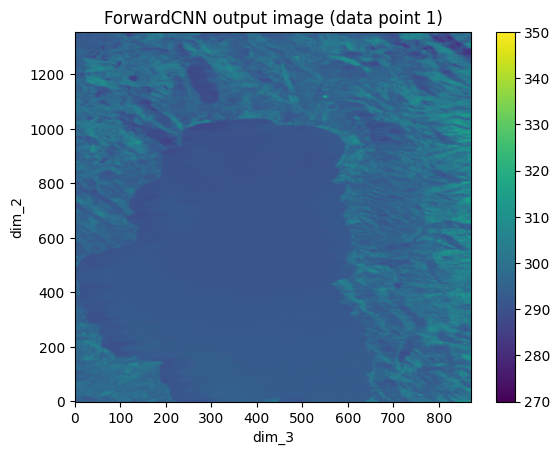

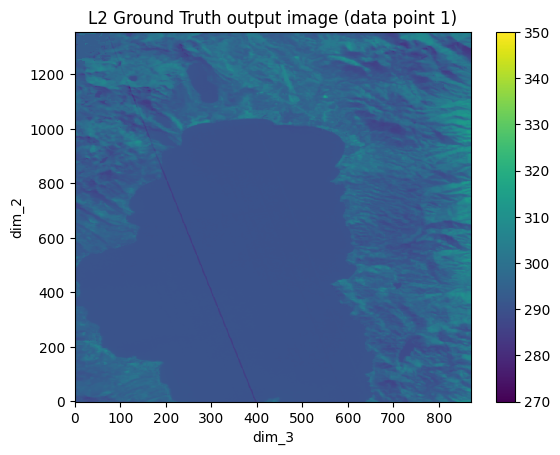

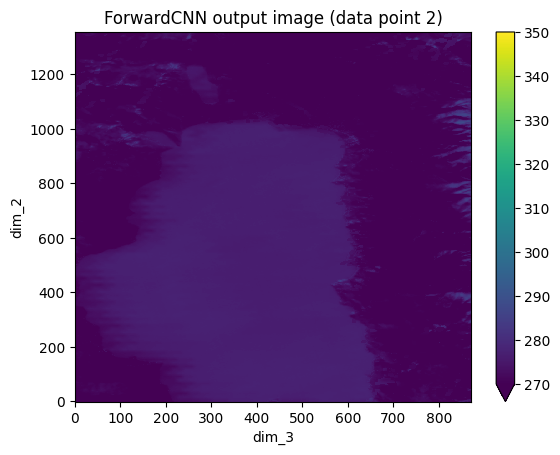

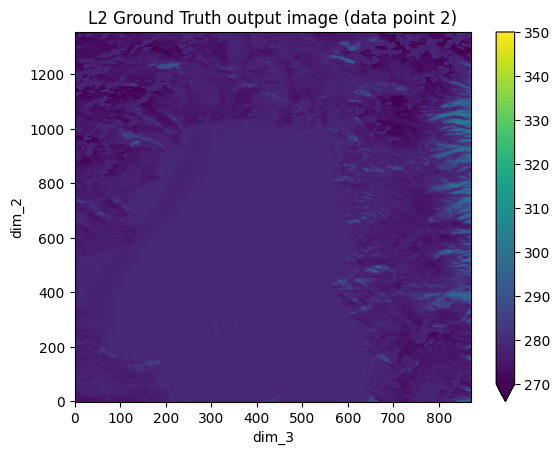

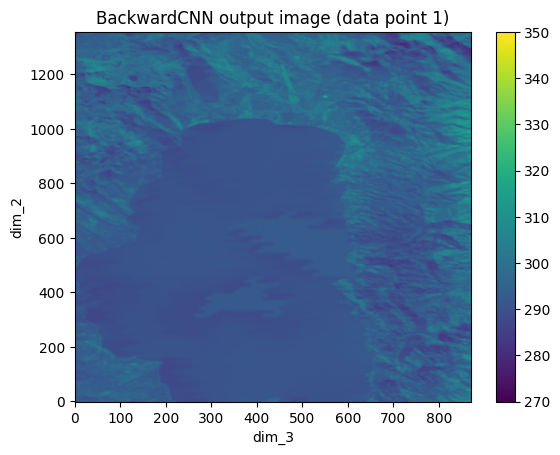

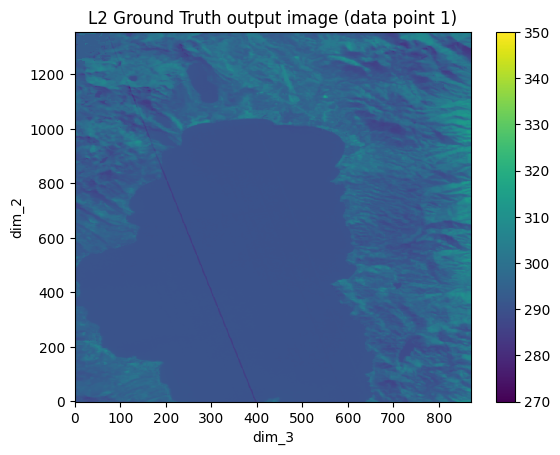

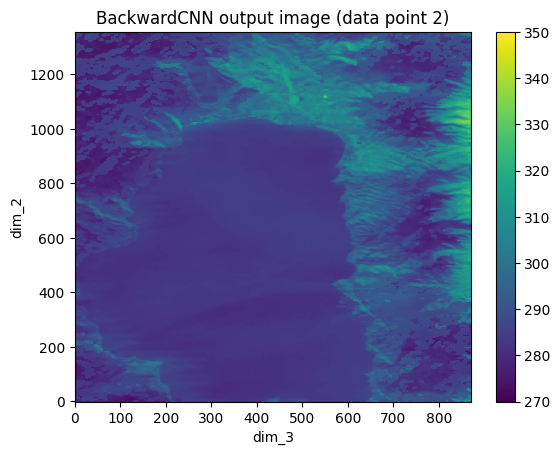

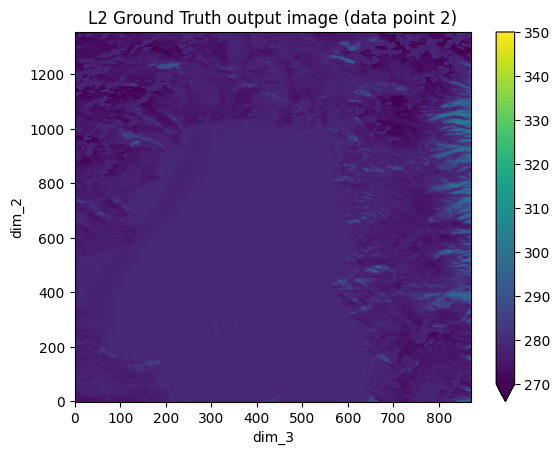

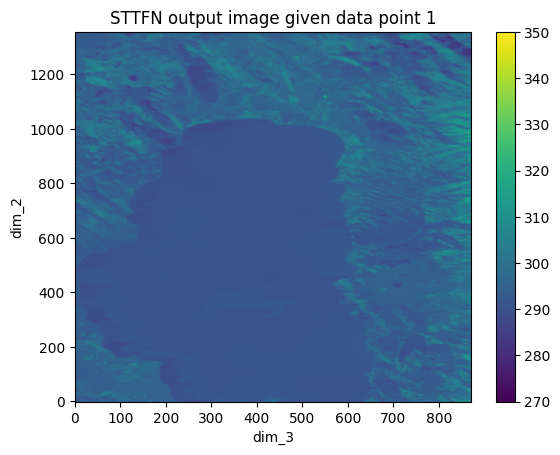

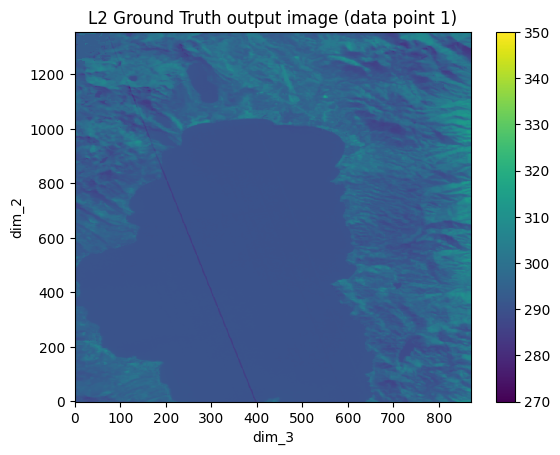

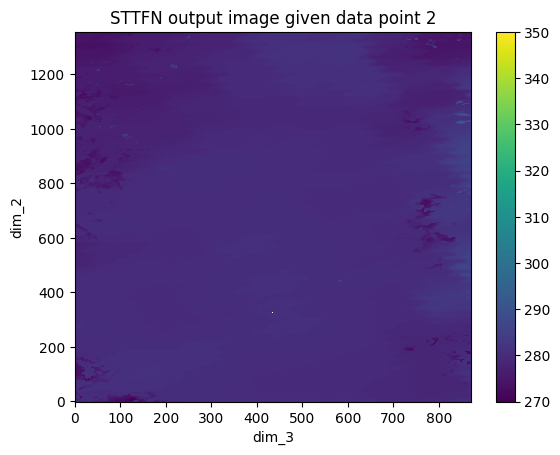

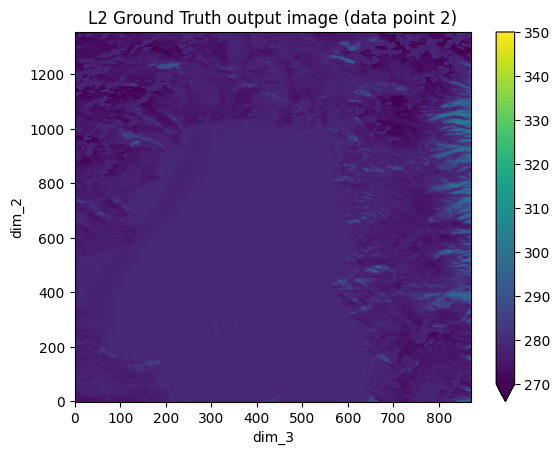

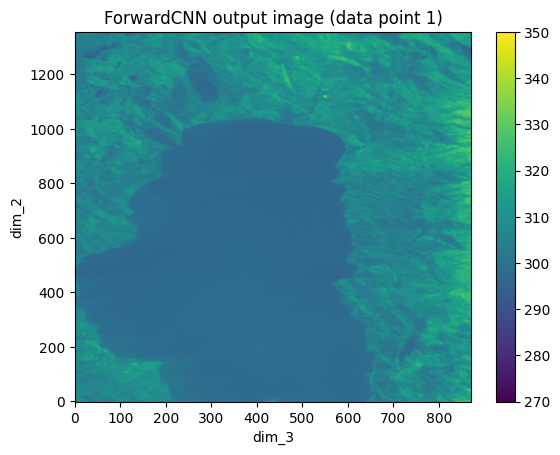

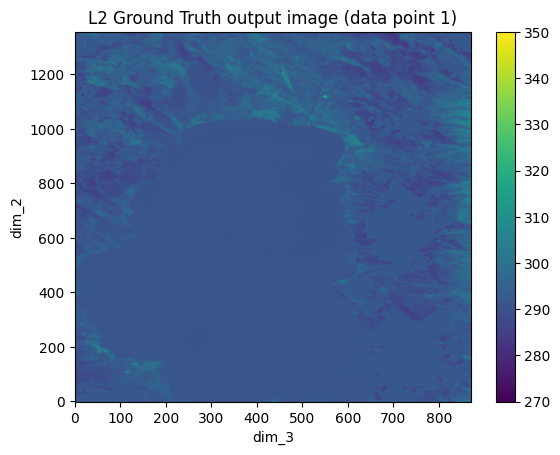

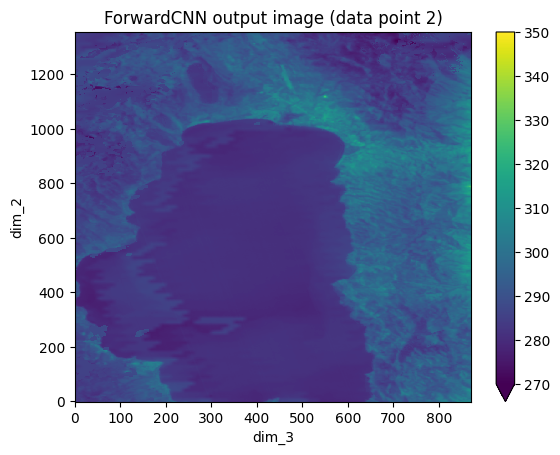

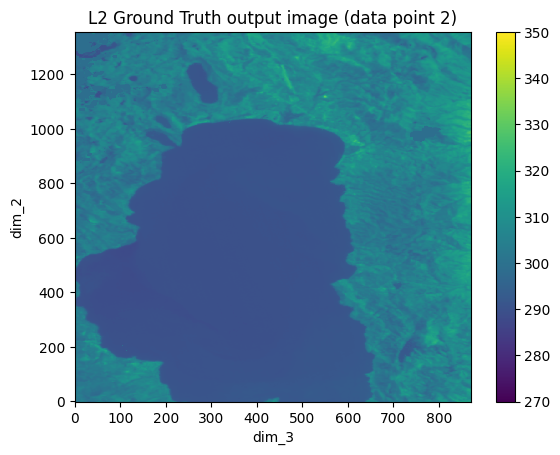

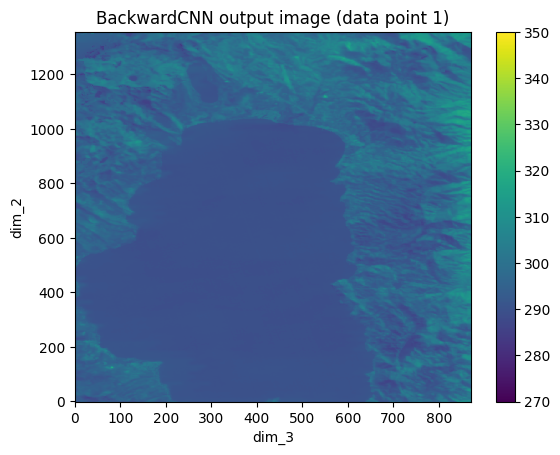

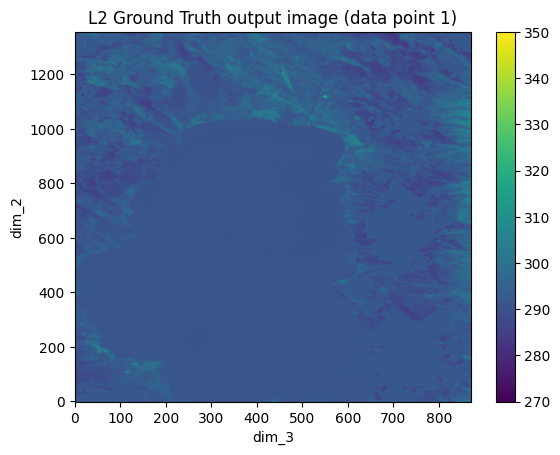

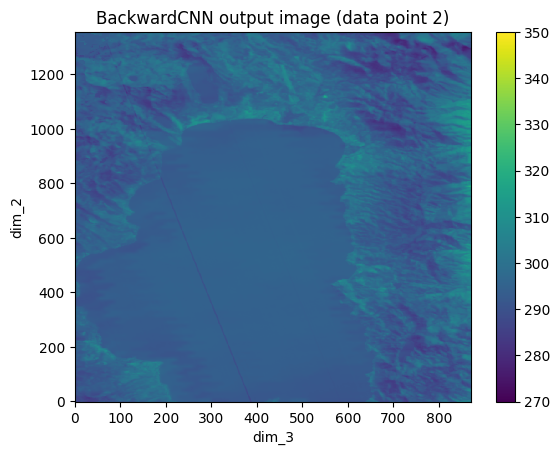

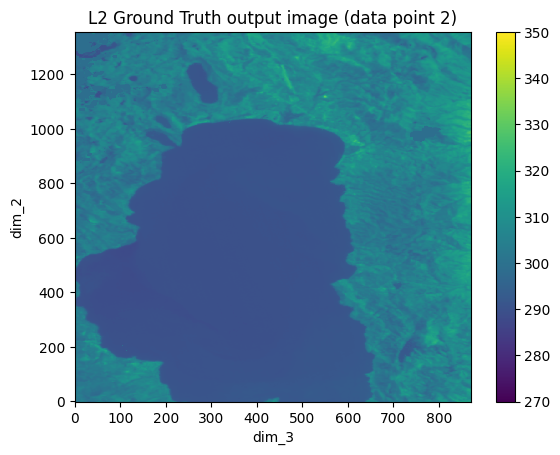

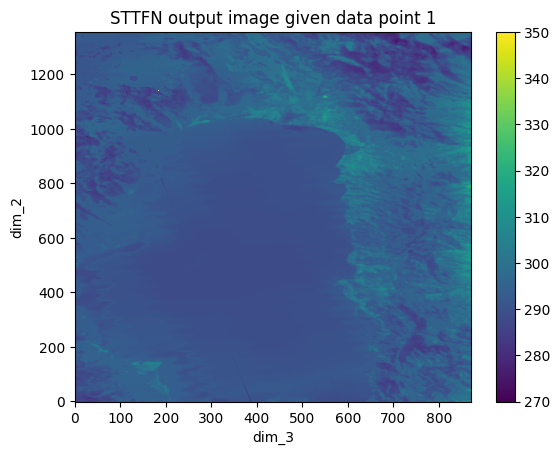

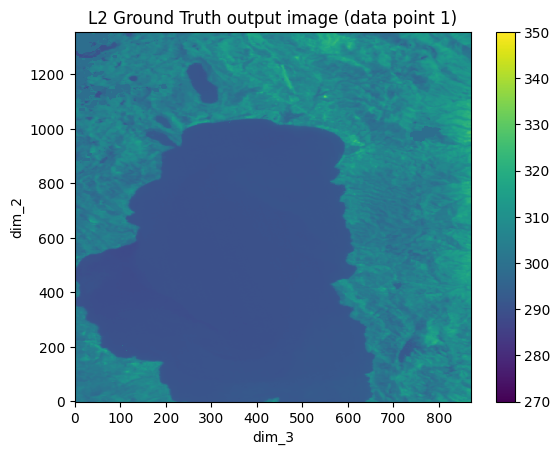

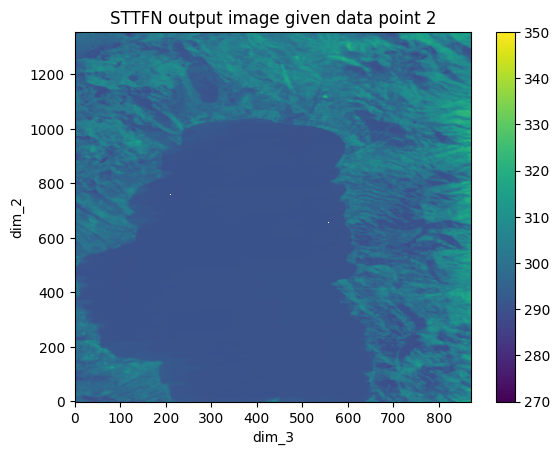

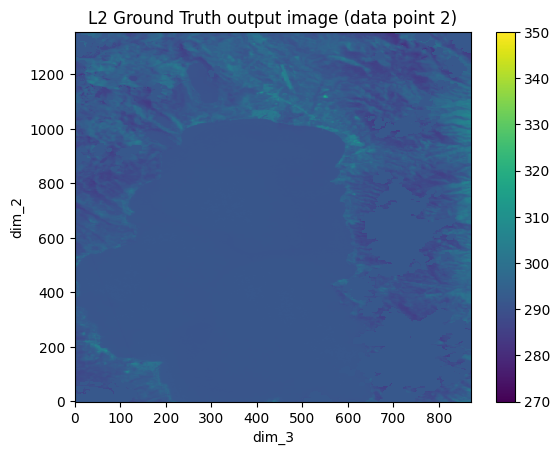

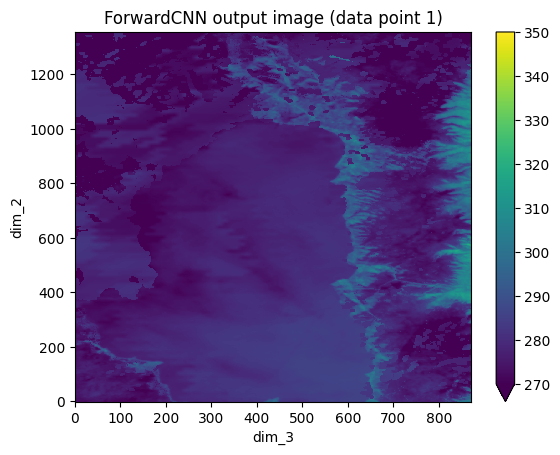

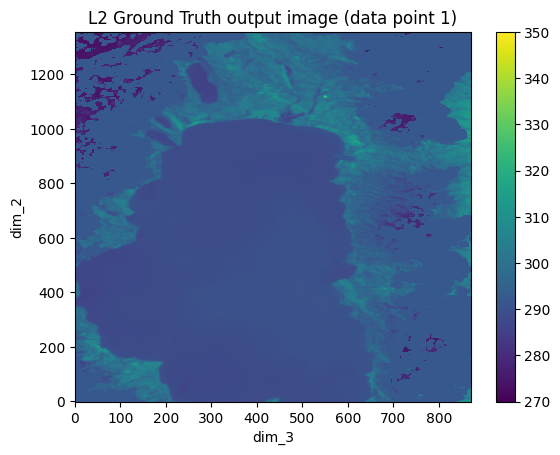

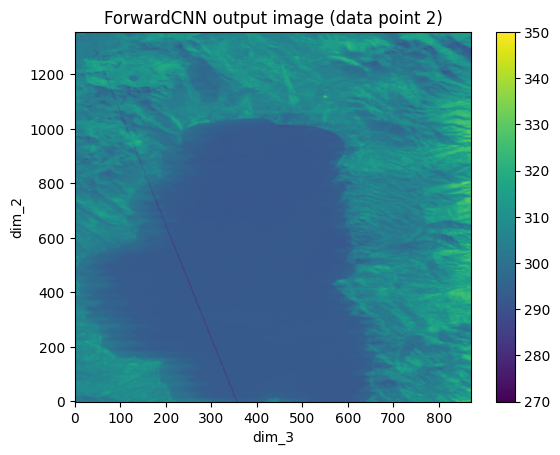

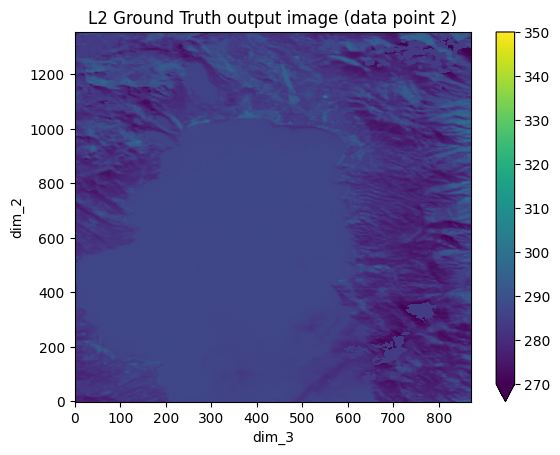

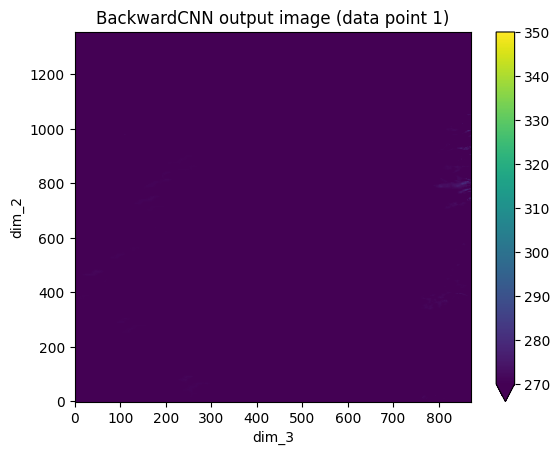

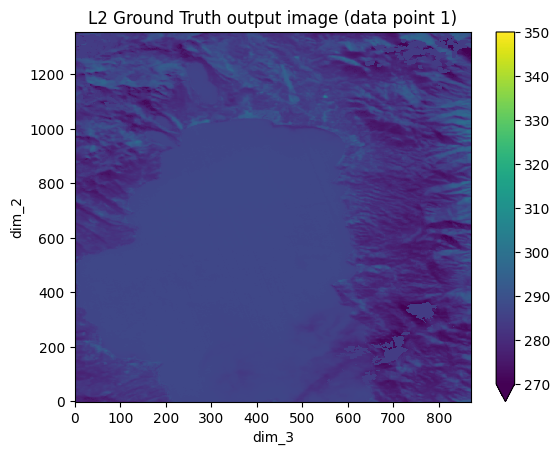

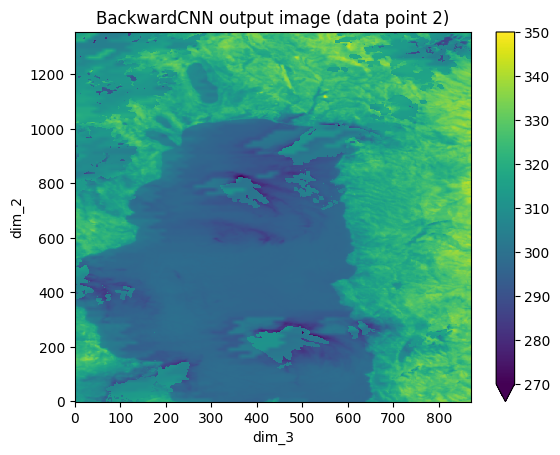

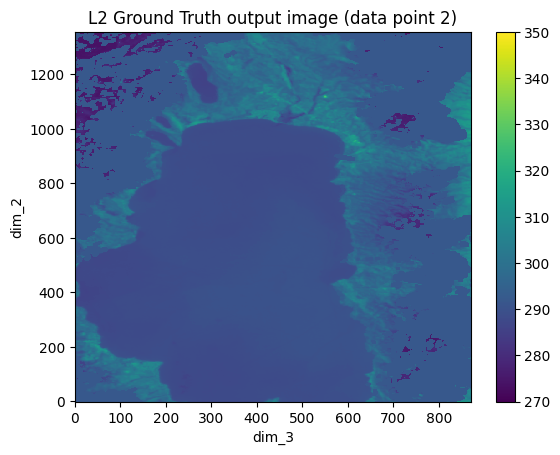

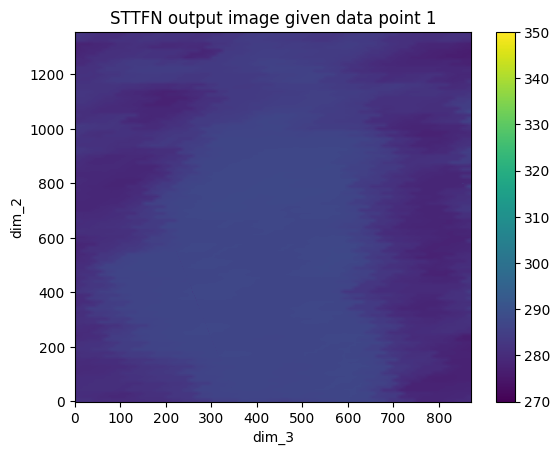

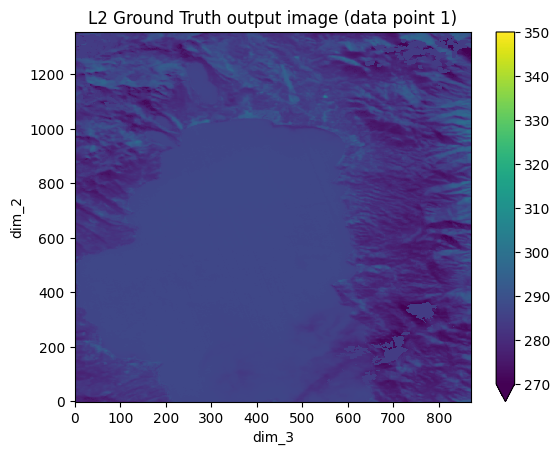

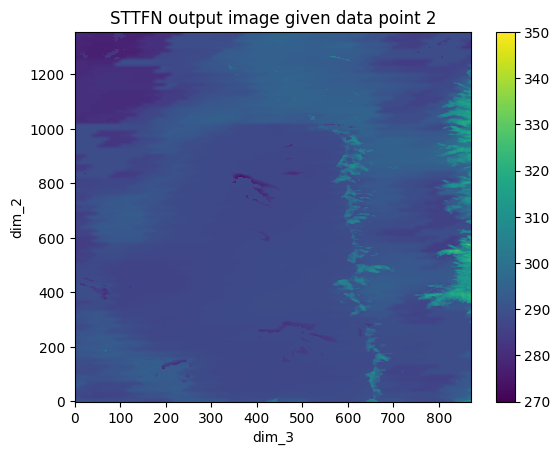

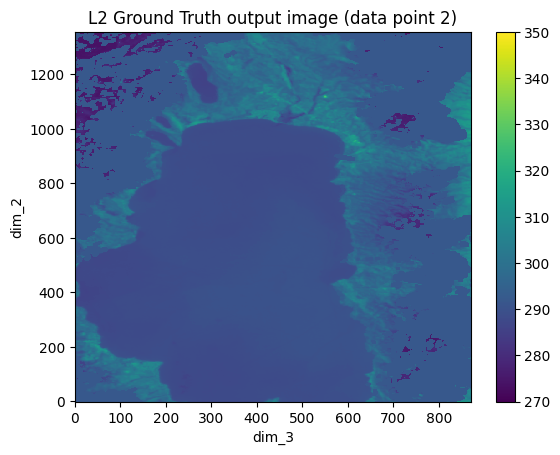

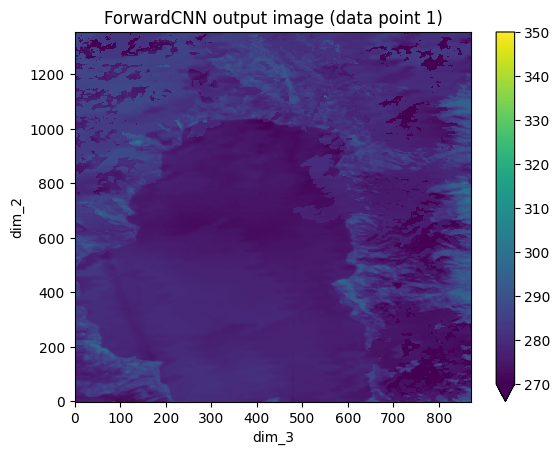

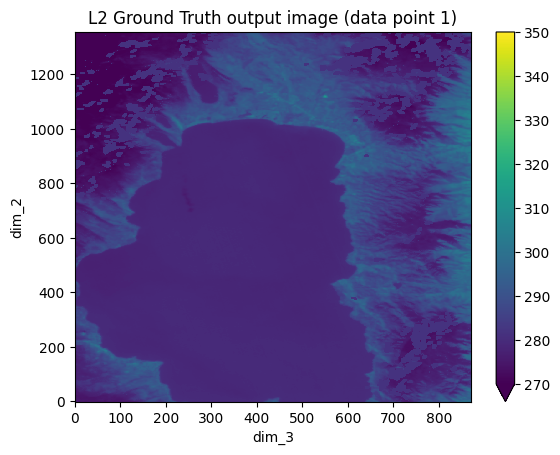

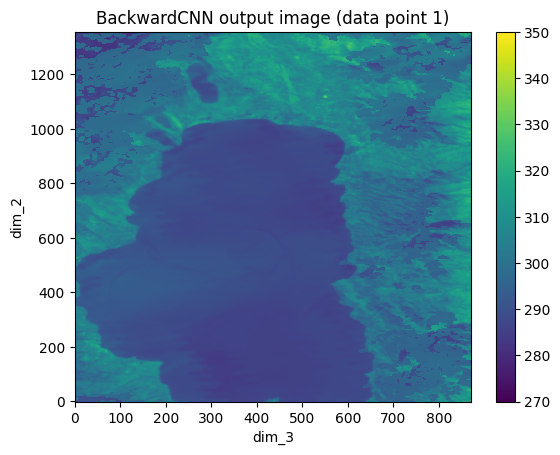

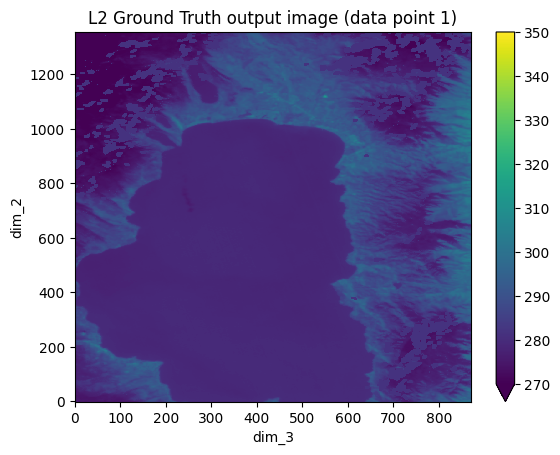

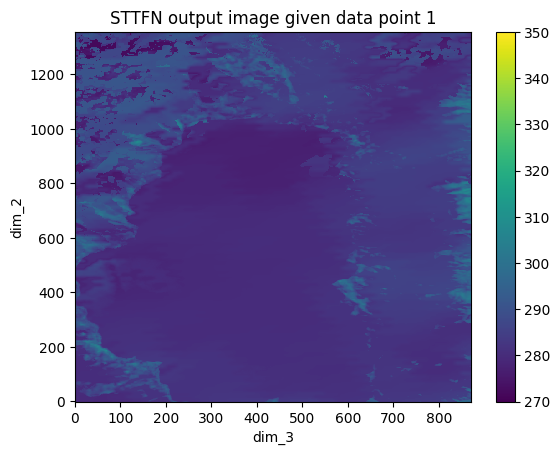

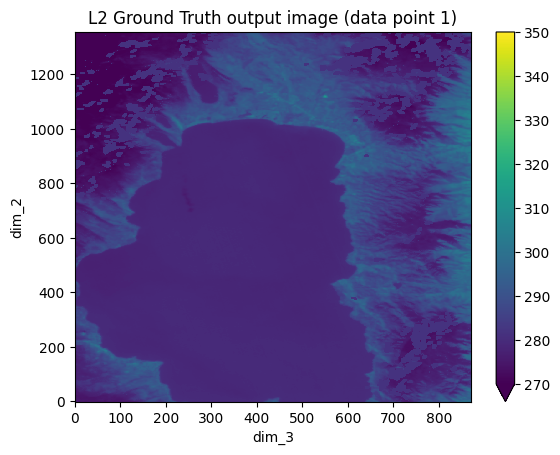

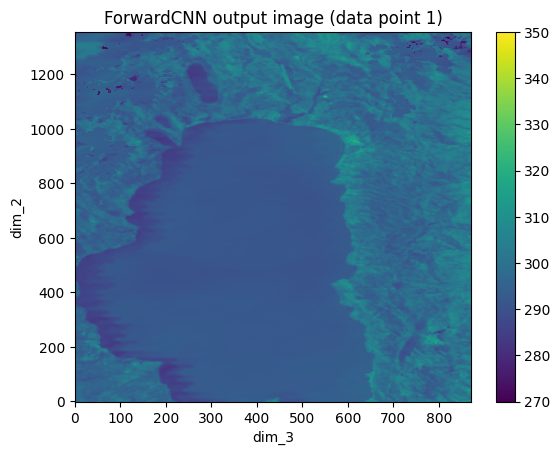

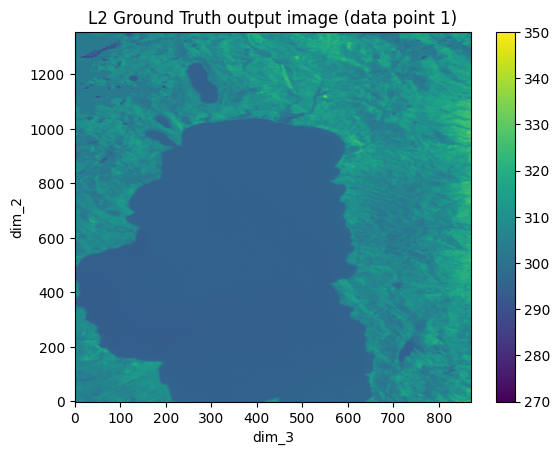

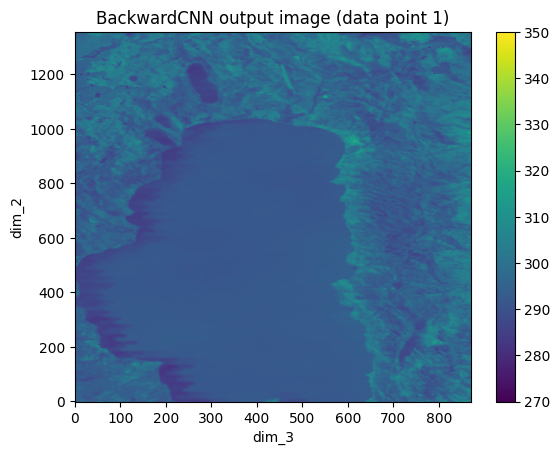

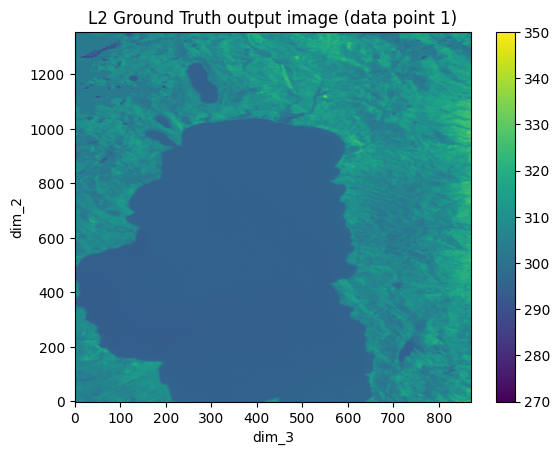

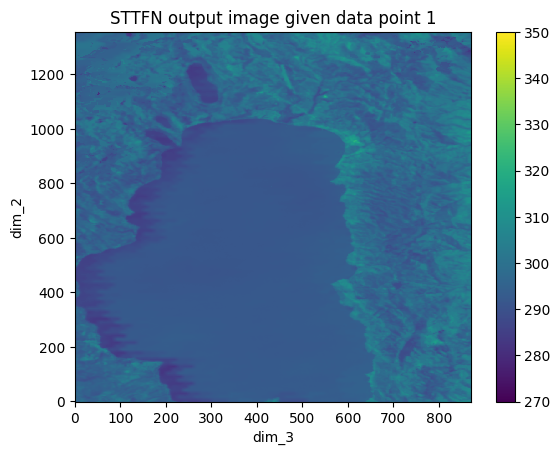

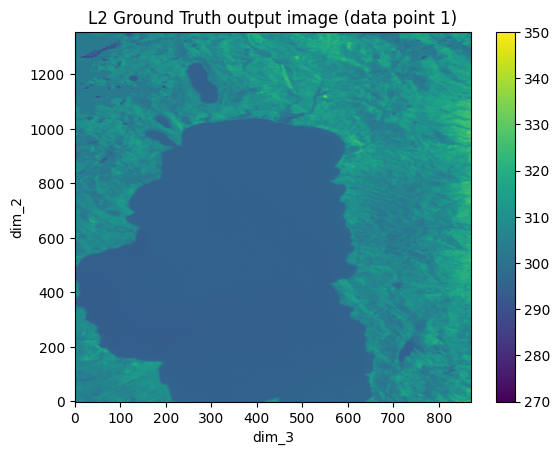

In [ ]:
def trainFusionCNN(fusionCNN, trainingLoader, cnnOptimizer, cnnCriterion, isForward = True):
  """
  Performs one epoch of training a fusionCNN. Returns average loss of epoch.
  """
  runningLoss = 0.0
  dpInPartition = 0
  for i, data in enumerate(trainingLoader, 1):

    # Get training datapoint
    trainingFeatures = None
    trainingLabel = None
    if isForward:
      trainingFeatures, _, trainingLabel, _, _ = data
    else:
      _, trainingFeatures, _, trainingLabel, _ = data

    trainingFeatures = [feature.to(device) for feature in trainingFeatures]
    trainingLabel = trainingLabel.to(device)
    torch.cuda.empty_cache() # to free memory

    dpInPartition += 1

    cnnOptimizer.zero_grad()

    modelOutput = fusionCNN.forward(*trainingFeatures)

    modelLoss = cnnCriterion(modelOutput, trainingLabel)

    modelLoss.backward()

    cnnOptimizer.step()

    runningLoss += modelLoss.item()

    if DEBUG_MODE:
      print(f'\t\t—— Data point {i} loss: {modelLoss.item()}')

  return runningLoss / dpInPartition



def getTrainedFusionCNN(trainingLoader, criterion, getForward = True, numEpochs = 1):
  """
  Trains a Fusion CNN model by performing the training loop over the specified
  number of epochs. Returns a Forward Fusion CNN if getForward = True or returns
  a Backward Fusion CNN if getForward = False.
  """
  cnnType = "ForwardCNN" if getForward else "BackwardCNN"
  print(f'—— {cnnType} training loop:')

  fusionCNN = FusionCNN().to(device)
  fusionCNN.train()
  for epoch in range(1, numEpochs + 1):
    if DEBUG_MODE:
      print(f'\t—— Epoch {epoch}:')

    learningRate = 0.00015 * (0.1 ** math.trunc((epoch - 1) / 10))
    cnnOptimizer = torch.optim.Adam(
        fusionCNN.parameters(),
        lr = learningRate
    )

    averageLoss = trainFusionCNN(fusionCNN, trainingLoader, cnnOptimizer, criterion)

    print(f'\t\t—— Epoch {epoch} {cnnType} average loss: {averageLoss}')

  return fusionCNN

def testSTTFN(sttfn, testingLoader):
  """
  Tests the STTFN against the data in testingLoader. Prints the results.
  """
  print("STTFN testing loop:")
  sttfn.eval()

  with torch.no_grad():
    runningRMSE = 0.0
    runningSSIM = 0.0
    dpInPartition = 0

    for i, data in enumerate(testingLoader, 1):
      # Get testing datapoint
      (L1, M1, _), (L3, M3, _), _, _, (L2, M2) = data
      testingFeatures = (L1, M1, M2, L3, M3)
      testingLabel = L2

      testingFeatures = [feature.to(device) for feature in testingFeatures]
      testingLabel = testingLabel.to(device)
      torch.cuda.empty_cache() # to free memory

      dpInPartition += 1

      sttfnOutput = sttfn.forward(*testingFeatures).to(device)

      rmse, ssim = evaluateModelOutput(sttfnOutput.cpu(), testingLabel.cpu())
      runningRMSE += rmse
      runningSSIM += ssim

      print(f'\t—— Data point {i}:')
      print(f'\t\t—— RMSE: {rmse}')
      print(f'\t\t—— SSIM: {ssim}')

      displayImageFigure(sttfnOutput.cpu(), f'STTFN output image given data point {i}')
      displayImageFigure(testingLabel.cpu(), f'L2 Ground Truth output image (data point {i})')

    print("\t—— STTFN testing average:")
    print(f'\t\t—— Root Mean Squared Error: {runningRMSE / dpInPartition}')
    print(f'\t\t—— Structural Similarity: {runningSSIM / dpInPartition}')



def testFusionCNN(fusionCNN, testingLoader, cnnCriterion, isForward = True):
  """
  Tests the model against the data in testingLoader. Prints the results.
  """
  cnnType = "ForwardCNN" if isForward else "BackwardCNN"
  print(f'—— {cnnType} testing loop:')
  fusionCNN.eval()

  with torch.no_grad():
    runningLoss = 0.0
    runningRMSE = 0.0
    runningSSIM = 0.0
    dpInPartition = 0

    for i, data in enumerate(testingLoader, 1):
      # Get testing datapoint
      testingFeatures = None
      testingLabel = None
      if isForward:
        (L1, M1, _), _, _, _, (L2, M2) = data
        testingFeatures = (L1, M1, M2)
        testingLabel = L2
      else:
        _, (L3, M3, _), _, _, (L2, M2) = data
        testingFeatures = (L3, M3, M2)
        testingLabel = L2

      testingFeatures = [feature.to(device) for feature in testingFeatures]
      testingLabel = testingLabel.to(device)
      torch.cuda.empty_cache() # to free memory

      dpInPartition += 1

      fusionCNNOutput = fusionCNN.forward(*testingFeatures)

      modelLoss = cnnCriterion(fusionCNNOutput, testingLabel).item()
      runningLoss += modelLoss

      rmse, ssim = evaluateModelOutput(fusionCNNOutput.cpu(), testingLabel.cpu())
      runningRMSE += rmse
      runningSSIM += ssim

      print(f'\t—— Data point {i}:')
      print(f'\t\t—— Loss: {modelLoss}')
      print(f'\t\t—— RMSE: {rmse}')
      print(f'\t\t—— SSIM: {ssim}')

      displayImageFigure(fusionCNNOutput.cpu(), f'{cnnType} output image (data point {i})')
      displayImageFigure(testingLabel.cpu(), f'L2 Ground Truth output image (data point {i})')

    print(f'\t—— {cnnType} testing average:')
    print(f'\t\t—— Loss: {runningLoss / dpInPartition}')
    print(f'\t\t—— Root Mean Squared Error: {runningRMSE / dpInPartition}')
    print(f'\t\t—— Structural Similarity: {runningSSIM / dpInPartition}')



print(f'KFold loop:')
kf = KFold(n_splits = min(len(tpdDataSet), 5), shuffle = True)
for fold, (trainSet, testSet) in enumerate(kf.split(tpdDataSet), 1):
  print(f'Fold {fold}:')

  trainingLoader = DataLoader(
      dataset = tpdDataSet,
      batch_size = None,
      sampler = torch.utils.data.SubsetRandomSampler(trainSet)
  )
  testingLoader = DataLoader(
      dataset = tpdDataSet,
      batch_size = None,
      sampler = torch.utils.data.SubsetRandomSampler(testSet)
  )

  fusionCNNCriterion = nn.HuberLoss(reduction = 'mean', delta = 1.0).to(device)

  ForwardCNN = getTrainedFusionCNN(
      trainingLoader,
      fusionCNNCriterion,
      getForward = True,
      numEpochs = 1 #Temporarily changing to 1 (was 40)
  )
  BackwardCNN = getTrainedFusionCNN(
      trainingLoader,
      fusionCNNCriterion,
      getForward = False,
      numEpochs = 1 #temporarily changing to 1 (was 40)
  )
  sttfn = STTFN(ForwardCNN, BackwardCNN)

  testFusionCNN(ForwardCNN, testingLoader, fusionCNNCriterion, isForward = True)
  testFusionCNN(BackwardCNN, testingLoader, fusionCNNCriterion, isForward = False)
  testSTTFN(sttfn, testingLoader)

## CNN Model Results (After CNN Training)


In [ ]:
testDataPoint = tpdDataSet[3]
# testDataPoint[0] = L1, M1, M3
# testDataPoint[1] = L3, M3, M1
# testDataPoint[2] = L3 (for training)
# testDataPoint[3] = L1 (for training)
# testDataPoint[4] = L2, M2
L1 = testDataPoint[0][0].to(device)
M1 = testDataPoint[0][1].to(device)
L2 = testDataPoint[4][0].to(device)
M2 = testDataPoint[4][1].to(device)
L3 = testDataPoint[1][0].to(device)
M3 = testDataPoint[0][2].to(device)


forwardOutput = ForwardCNN.forward(L1, M1, M2)
forwardOutputXArray = ConvertTensorToXArray(forwardOutput.cpu())
print(forwardOutputXArray.shape)
imageArray = forwardOutputXArray[0, 0, :, :]
print(imageArray.shape)


## Model Output (Trying to predict L3)
fig, ax = plt.subplots()
imageArray.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX)

ax.set_title("Model Output")

## The target landsat (L3)
fig, ax = plt.subplots()
L3_XArray = ConvertTensorToXArray(L3.cpu())
L3_Array = L3_XArray[0, 0, :, :]
L3_Array.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
#datetime = pd.to_datetime(masked_lst.time.to_pandas()).strftime('Landsat\n%B %d, %Y\nTime: %I:%M:%S %p')
ax.set_title("Target Landsat (D1)")


## The target modis (M3)
fig, ax = plt.subplots()
M3_XArray = ConvertTensorToXArray(M3.cpu())
M3_Array = M3_XArray[0, 0, :, :]
M3_Array.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
ax.set_title("Target (Given) MODIS (D1)")

## The Adjacent Modis (M1)
fig, ax = plt.subplots()
M1_XArray = ConvertTensorToXArray(M1.cpu())
M1_Array = M1_XArray[0, 0, :, :]
M1_Array.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
ax.set_title("Adjacent (Given) MODIS (D0)")

## The Adjacent Landsat (L1)
fig, ax = plt.subplots()
L1_XArray = ConvertTensorToXArray(L1.cpu())
L1_Array = L1_XArray[0, 0, :, :]
L1_Array.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
ax.set_title("Adjacent (Given) Landsat (D0)")

# Testing the STTFN

In [ ]:
# Grab an example datapoint
testDataPoint = tpdDataSet[3]
# testDataPoint[0] = L1, M1, M3
# testDataPoint[1] = L3, M3, M1
# testDataPoint[2] = L3 (for training)
# testDataPoint[3] = L1 (for training)
# testDataPoint[4] = L2, M2
L1 = testDataPoint[0][0].to(device)
M1 = testDataPoint[0][1].to(device)
L2 = testDataPoint[4][0].to(device)
M2 = testDataPoint[4][1].to(device)
L3 = testDataPoint[1][0].to(device)
M3 = testDataPoint[0][2].to(device)
STTFN_Output = sttfn.forward(L1, M1, M2, L3, M3)


STTFN_Output_XArray = ConvertTensorToXArray(STTFN_Output.cpu())

outputImageArray = STTFN_Output_XArray[0, 0, :, :]
print(outputImageArray.shape)

## Model Output (Trying to predict L2)
fig, ax = plt.subplots()
outputImageArray.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX)
ax.set_title("Model Output")


## Model Output Accuracy using RMSE
## Note: The Tensors need to be converted to XArray, then to NP Array for SSIM and MSE.
L2_XArray = ConvertTensorToXArray(L2.cpu())[0, 0, :, :]
L2_NP = L2_XArray.values
Output_NP = outputImageArray.values

# Clean NP's (So many conversions could introduce NaN values)
if (np.isnan(L2_NP).any()):
  L2_NP = np.nan_to_num(L2_NP)

if (np.isinf(L2_NP).any()):
  L2_NP = np.nan_to_num(L2_NP, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)

if (np.isnan(Output_NP).any()):
  Output_NP = np.nan_to_num(Output_NP)

if (np.isinf(Output_NP).any()):
  Output_NP = np.nan_to_num(Output_NP, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)


print(f'L2 shape: {L2_NP.shape}')
print(f'STTFN Output shape: {Output_NP.shape}')
meanSqError = mse(L2_NP, Output_NP)
rmse = math.sqrt(meanSqError)

## Model Output Accuracy using Structural Similarity index
data_range = Output_NP.max() - Output_NP.min()
structuralSimilarity = ssim(L2_NP, Output_NP, data_range = data_range)

print(f'Root Mean Squared Error of model prediction: {rmse}')
print(f'Structural Similarity between model prediction and ground truth {structuralSimilarity}')


## The target landsat (L2)
fig, ax = plt.subplots()
L2_XArray = ConvertTensorToXArray(L2.cpu())
L2_Array = L2_XArray[0, 0, :, :]
L2_Array.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
ax.set_title("Target Landsat (D2)")

## The target modis (M2)
fig, ax = plt.subplots()
M2_XArray = ConvertTensorToXArray(M2.cpu())
M2_Array = M2_XArray[0, 0, :, :]
M2_Array.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
ax.set_title("Target (Given) MODIS (D2)")

## The Adjacent Modis (M1)
fig, ax = plt.subplots()
M1_XArray = ConvertTensorToXArray(M1.cpu())
M1_Array = M1_XArray[0, 0, :, :]
M1_Array.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
ax.set_title("Adjacent (Given) MODIS (D1)")

## The Adjacent Landsat (L1)
fig, ax = plt.subplots()
L1_XArray = ConvertTensorToXArray(L1.cpu())
L1_Array = L1_XArray[0, 0, :, :]
L1_Array.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
ax.set_title("Adjacent (Given) Landsat (D1)")

## The Adjacent Modis (M3)
fig, ax = plt.subplots()
M3_XArray = ConvertTensorToXArray(M3.cpu())
M3_Array = M3_XArray[0, 0, :, :]
M3_Array.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
ax.set_title("Adjacent (Given) MODIS (D3)")

## The Adjacent Landsat (L3)
fig, ax = plt.subplots()
L3_XArray = ConvertTensorToXArray(L3.cpu())
L3_Array = L3_XArray[0, 0, :, :]
L3_Array.plot.imshow(ax=ax, vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
ax.set_title("Adjacent (Given) Landsat (D3)")


# STARFM Model

In [ ]:
# Wrap the model's parameters in a class and call them in the Starfm's test run and model.

class StarFM:

  def __init__(self):
    # Set the size of the moving window in which the search for similar pixels
    # is performed
    self.windowSize = 31

    # Set the path where the results should be stored
    self.path = 'STARFM_demo/'

    # Set to True if you want to decrease the sensitivity to the spectral distance
    self.logWeight = False

    # If more than one training pairs are used, set to True
    self.temp = False

    # The spatial impact factor is a constant defining the relative importance of
    # spatial distance (in meters)
    # Take a smaller value of the spatial impact factor for heterogeneous regions
    # (e.g. A = 150 m)
    self.spatImp = 150

    # increasing the number of classes limits the number of similar pixels
    self.numberClass = 4

    # Set the uncertainty value for the fine resolution sensor
    # https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/performance
    self.uncertaintyFineRes = 0.03

    # Set the uncertainty value for the coarse resolution sensor
    # https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-3-olci/validation
    self.uncertaintyCoarseRes = 0.03

    # Other global variables
    self.mid_idx = (self.windowSize**2)//2
    self.specUncertainty = np.sqrt(self.uncertaintyFineRes**2 + self.uncertaintyCoarseRes**2)
    self.tempUncertainty = np.sqrt(2*self.uncertaintyCoarseRes**2)


  # Flatten blocks inside a dask array
  def block2row(self, array, row, folder, block_id=None):
      if array.shape[0] == self.windowSize:
          # Parameters
          name_string = str(block_id[0] + 1)
          m, n = array.shape
          u = m + 1 - self.windowSize
          v = n + 1 - self.windowSize

        # Get Starting block indices
          start_idx = np.arange(u)[:,None]*n + np.arange(v)

        # Get offsetted indices across the height and width of input array
          offset_idx = np.arange(self.windowSize)[:,None]*n + np.arange(self.windowSize)

        # Get all actual indices & index into input array for final output
          flat_array = np.take(array,start_idx.ravel()[:,None] + offset_idx.ravel())

          # Save to (dask) array in .zarr format
          file_name = self.path + folder + name_string + 'r' + row + '.zarr'
          zarr.save(file_name, flat_array)

      return array


  # Divide an image in overlapping blocks
  def partition(self, image, folder):
      image_da = da.from_array(image, chunks = (self.windowSize,image.shape[1]))
      image_pad = da.pad(image_da, self.windowSize//2, mode='constant')

      for i in range(0, self.windowSize):
          row = str(i)
          block_i = image_pad[i:,:]
          block_i_da = da.rechunk(block_i, chunks=(self.windowSize,image_pad.shape[1]))
          block_i_da.map_blocks(self.block2row, dtype=int, row=row, folder=folder).compute()


  # Create a list of all files in the folder and stack them into one dask array
  def da_stack(self, folder, shape):
      da_list = []
      full_path = self.path + folder
      max_blocks = shape[0]//self.windowSize + 1

      for block in range(1,max_blocks + 1):
          for row in range(0, self.windowSize):
              name = str(block) + 'r' + str(row)
              full_name = full_path + name + '.zarr'
              try:
                  da_array = da.from_zarr(full_name)
                  da_list.append(da_array)
              except Exception:
                  continue

      return da.rechunk(da.concatenate(da_list, axis=0), chunks = (shape[1], self.windowSize**2))


  # Calculate the spectral distance
  def spectral_distance(self, fine_image_t0, coarse_image_t0):
      spec_diff = fine_image_t0 - coarse_image_t0
      spec_dist = 1/(abs(spec_diff) + 1.0)
      print ("Done spectral distance!", spec_dist)

      return spec_diff, spec_dist


  # Calculate the temporal distance
  def temporal_distance(self, coarse_image_t0, coarse_image_t1):
      temp_diff = coarse_image_t1 - coarse_image_t0
      temp_dist = 1/(abs(temp_diff) + 1.0)
      print ("Done temporal distance!", temp_dist)

      return temp_diff, temp_dist


  # Calculate the spatial distance
  def spatial_distance(self, array):
      coord = np.sqrt((np.mgrid[0:self.windowSize,0:self.windowSize]-self.windowSize//2)**2)
      spat_dist = np.sqrt(((0-coord[0])**2+(0-coord[1])**2))
      rel_spat_dist = spat_dist/self.spatImp + 1.0 # relative spatial distance
      rev_spat_dist = 1/rel_spat_dist # relative spatial distance reversed
      flat_spat_dist = np.ravel(rev_spat_dist)
      spat_dist_da = da.from_array(flat_spat_dist, chunks=flat_spat_dist.shape)
      print ("Done spatial distance!", spat_dist_da)

      return spat_dist_da


  # Define the threshold used in the dynamic classification process
  def similarity_threshold(self, fine_image_t0):#, st_dev):
      fine_image_t0 = da.where(fine_image_t0==0, np.nan, fine_image_t0)
      st_dev = da.nanstd(fine_image_t0, axis=1)# new
      sim_threshold = st_dev*2/self.numberClass
      print ("Done similarity threshold!", sim_threshold)

      return sim_threshold


  # Define the spectrally similar pixels within a moving window
  def similarity_pixels(self, fine_image_t0):
      sim_threshold = self.similarity_threshold(fine_image_t0)
      # possible to implement as sparse matrix
      similar_pixels = da.where(abs(fine_image_t0 -
                                    fine_image_t0[:, self.mid_idx][:,None])
          <= sim_threshold[:,None], 1, 0) #sim_threshold[:,mid_idx][:,None], 1, 0) # new
      print ("Done similarity pixels!", similar_pixels)

      return similar_pixels


  # Apply filtering on similar pixels
  def filtering(self, fine_image_t0, spec_dist, temp_dist, spec_diff, temp_diff):
      similar_pixels = self.similarity_pixels(fine_image_t0)
      max_spec_dist = abs(spec_diff)[:, self.mid_idx][:,None] + self.specUncertainty + 1
      max_temp_dist = abs(temp_diff)[:, self.mid_idx][:,None] + self.tempUncertainty + 1
      spec_filter = da.where(spec_dist>1.0/max_spec_dist, 1, 0)
      st_filter = spec_filter

      if self.temp == True:
          temp_filter = da.where(temp_dist>1.0/max_temp_dist, 1, 0)
          st_filter = spec_filter*temp_filter

      similar_pixels_filtered = similar_pixels*st_filter
      print ("Done filtering!", similar_pixels_filtered)

      return similar_pixels_filtered # sim_pixels_sparse


  # Calculate the combined distance
  def comb_distance(self, spec_dist, temp_dist, spat_dist):
      if self.logWeight == True:
          spec_dist = da.log(spec_dist + 1)
          temp_dist = da.log(temp_dist + 1)

      comb_dist = da.rechunk(spec_dist*temp_dist*spat_dist,
                            chunks=spec_dist.chunksize)
      print ("Done comb distance!", comb_dist)

      return comb_dist


  # Calculate weights
  def weighting(self, spec_dist, temp_dist, comb_dist, similar_pixels_filtered):
      # Assign max weight (1) when the temporal or spectral distance is zero
      zero_spec_dist = da.where(spec_dist[:,self.mid_idx][:,None] == 1, 1, 0)
      zero_temp_dist = da.where(temp_dist[:,self.mid_idx][:,None] == 1, 1, 0)
      zero_dist_mid = da.where((zero_spec_dist == 1),
                              zero_spec_dist, zero_temp_dist)
      shape = da.subtract(spec_dist.shape,(0,1))
      zero_dist = da.zeros(shape, chunks=(spec_dist.shape[0],shape[1]))
      zero_dist = da.insert(zero_dist, [self.mid_idx], zero_dist_mid, axis=1)
      weights = da.where((da.sum(zero_dist,1)[:,None] == 1), zero_dist, comb_dist)

      # Calculate weights only for the filtered spectrally similar pixels
      weights_filt = weights*similar_pixels_filtered

      # Normalize weights
      norm_weights = da.rechunk(weights_filt/(da.sum(weights_filt,1)[:,None]),
                                chunks = spec_dist.chunksize)

      print ("Done weighting!", norm_weights)

      return norm_weights


  # Derive fine resolution reflectance for the day of prediction
  def predict(self, fine_image_t0, coarse_image_t0, coarse_image_t1, shape):
      spec = self.spectral_distance(fine_image_t0, coarse_image_t0)
      spec_diff = spec[0]
      spec_dist = spec[1]
      temp = self.temporal_distance(coarse_image_t0, coarse_image_t1)
      temp_diff = temp[0]
      temp_dist = temp[1]
      spat_dist = self.spatial_distance(fine_image_t0)
      comb_dist = self.comb_distance(spec_dist, temp_dist, spat_dist)
      similar_pixels = self.filtering(fine_image_t0, spec_dist, temp_dist, spec_diff,
                                temp_diff)
      weights = self.weighting(spec_dist, temp_dist, comb_dist, similar_pixels)
      pred_refl = fine_image_t0 + temp_diff
      weighted_pred_refl = da.sum(pred_refl*weights, axis=1)
      prediction = da.reshape(weighted_pred_refl, shape)
      print("Done prediction!")

      return prediction


  # Compute the results (converts the dask array to a numpy array)
  def starfm(self, fine_image_t0, coarse_image_t0, coarse_image_t1, shape):
      print ('Processing...')
      prediction_da = self.predict(fine_image_t0, coarse_image_t0, coarse_image_t1, shape)
      with ProgressBar():
          prediction = prediction_da.compute()

      return prediction



sfm = StarFM()


# StarFM Test Run

In [ ]:
start = time.time()


# We'll use a triple dataset pair and see if we can run it through the model.
# From the triple dataset pair, we need the past pair and the date of interest's
# modis image to predict the doi's landsat image.

starfmTestTD = trainingDataSet[TEST_POINT]
# testDataPoint[0] = L1, M1, M3
# testDataPoint[1] = L3, M3, M1
# testDataPoint[2] = L3 (for training)
# testDataPoint[3] = L1 (for training)
# testDataPoint[4] = L2, M2

MODISt1 = ConvertTensorToXArray(starfmTestTD[0][1]).isel(dim_0=0, dim_1=0)
LandsatT1 = ConvertTensorToXArray(starfmTestTD[0][0]).isel(dim_0=0, dim_1=0)
MODISt2 = ConvertTensorToXArray(starfmTestTD[4][1]).isel(dim_0=0, dim_1=0)
LandsatT2 = ConvertTensorToXArray(starfmTestTD[4][0]).isel(dim_0=0, dim_1=0)

shape = (LandsatT1.shape[0], LandsatT1.shape[1])
print(f'Landsat shape: {shape}')


# Set the path where to store the temporary results
path_fineRes_t1 = 'Temporary/Tiles_fineRes_t1/'
path_coarseRes_t1 = 'Temporary/Tiles_coarseRes_t1/'
path_coarseRes_t2 = 'Temporary/Tiles_fcoarseRes_t2/'


# Flatten and store the moving window patches
fine_image_t1_par = sfm.partition(LandsatT1, path_fineRes_t1)
coarse_image_t1_par = sfm.partition(MODISt1, path_coarseRes_t1)
coarse_image_t2_par = sfm.partition(MODISt2, path_coarseRes_t2)

print ("Done partitioning!")

# Stack the the moving window patches as dask arrays
S2_t1 = sfm.da_stack(path_fineRes_t1, LandsatT1.shape)
S3_t1 = sfm.da_stack(path_coarseRes_t1, MODISt1.shape)
S3_t2 = sfm.da_stack(path_coarseRes_t2, MODISt2.shape)

shape = (LandsatT1.shape[0], LandsatT1.shape[1])

print ("Done stacking!")

# Perform the prediction with STARFM
for i in range(0, LandsatT1.size-shape[0]*shape[1]+1, shape[0]*shape[1]):
    fine_image_t1 = S2_t1[i:i+shape[0]*shape[1],]
    coarse_image_t1 = S3_t1[i:i+shape[0]*shape[1],]
    coarse_image_t2 = S3_t2[i:i+shape[0]*shape[1],]
    prediction = sfm.starfm(fine_image_t1, coarse_image_t1, coarse_image_t2, shape)

    if i == 0:
        predictions = prediction

    else:
        predictions = np.append(predictions, prediction, axis=0)


# Write the results to a .tif file
print('Writing product...')
#profile.update(dtype='float64', count=1) # number of bands
file_name = sfm.path + 'prediction.tif'

result = rasterio.open(file_name, 'w', driver='GTiff',
    height=len(LandsatT1['dim_3']),
    width=len(LandsatT1['dim_2']),
    count=1,
    dtype='float64',)

result.write(predictions, 1)
result.close()


end = time.time()
print ("Done in", (end - start)/60.0, "minutes!")

# Display input and output
print(result)
plt.title("Prediction (L2)")
plt.imshow(predictions, cmap="viridis", vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
plt.colorbar()
plt.show()

plt.title("Ground Truth (Actual L2)")
plt.imshow(LandsatT2, cmap="viridis", vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
plt.colorbar()
plt.show()


plt.title("Landsat T1")
plt.imshow(LandsatT1, cmap="viridis", vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
plt.colorbar()
plt.show()
plt.title("MODIS T1")
plt.imshow(MODISt1, cmap="viridis", vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
plt.colorbar()
plt.show()
plt.title("MODIS T2")
plt.imshow(MODISt2, cmap="viridis", vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
plt.colorbar()
plt.show()




# Testing Results

In [ ]:
# Calculate the RMSE and SSIM between StarFM and STTFN and compare the output images with the ground truth.

## Model Output Accuracy using RMSE for STARFM
## Note: The Tensors need to be converted to XArray, then to NP Array for SSIM and MSE.
L2_NP_starfm = (ConvertTensorToXArray(L2)[0, 0, :, :]).values
Output_NP_starfm = predictions

# Clean NP's (So many conversions could introduce NaN values)
if (np.isnan(L2_NP_starfm).any()):
  L2_NP_starfm = np.nan_to_num(L2_NP_starfm)

if (np.isinf(L2_NP_starfm).any()):
  L2_NP_starfm = np.nan_to_num(L2_NP_starfm, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)

if (np.isnan(Output_NP_starfm).any()):
  Output_NP_starfm = np.nan_to_num(Output_NP_starfm)

if (np.isinf(Output_NP_starfm).any()):
  Output_NP_starfm = np.nan_to_num(Output_NP_starfm, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)

meanSqError_starfm = mse(L2_NP_starfm, Output_NP_starfm)
rmse_starfm = math.sqrt(meanSqError_starfm)

## Model Output Accuracy using Structural Similarity index
data_range_starfm = Output_NP_starfm.max() - Output_NP_starfm.min()
structuralSimilarity_starfm = ssim(L2_NP_starfm, Output_NP_starfm, data_range = data_range)

print(f'Root Mean Squared Error of StarFM prediction: {rmse_starfm}')
print(f'Root Mean Squared Error of STTFN prediction: {rmse}')
print(f'Structural Similarity between StarFM prediction and ground truth {structuralSimilarity_starfm}')
print(f'Structural Similarity between STTFN prediction and ground truth {structuralSimilarity}')

plt.title("StarFM Prediction (L2)")
plt.imshow(predictions, cmap="viridis", vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
plt.colorbar()
plt.show()


STTFN_Output_XArray = ConvertTensorToXArray(STTFN_Output)
outputImageArray1 = STTFN_Output_XArray[0, 0, :, :]
plt.title("STTFN Prediction (L2)")
plt.imshow(outputImageArray.values, cmap="viridis", vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
plt.colorbar()
plt.show()


plt.title("Ground Truth (Actual L2)")
plt.imshow(LandsatT2, cmap="viridis", vmin=LEGEND_MIN, vmax=LEGEND_MAX,)
plt.colorbar()
plt.show()